In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from matplotlib.animation import FuncAnimation
from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import gaussian_filter

In [3]:
mu = np.array([0.5, 0])
Sigma = np.array([[0.07**2, 0], [0, 0.02**2]])  # identity matrix for rho = 0
Sigma_inv = np.linalg.inv(Sigma)
Sigma_det = np.linalg.det(Sigma)

# Multivariate normal density function using matrix form
def bivariate_normal(pos, mu, Sigma_inv, Sigma_det):
    diff = pos - mu
    exponent = -0.5 * np.einsum('...k,kl,...l->...', diff, Sigma_inv, diff)
    return 0.0565+0.9*np.exp(exponent)

In [4]:
def U_eq(rho):
    return u_max*(1-rho/rho_max)
def V_eq(rho, y):
    return v_max*(np.exp(-(b+y)/2)-np.exp(-(b-y)/2))*(1-rho/rho_max)
    
def FPK(m, n, o, dt, dx, dy, rho, u, v, d1, d2, sigma):
    for j in range(m-1):
        for i in range(n):
            for l in range(o):
                if i == n-1:
                    if l == 0:
                        rho[j+1, i, l] = 1/4*(rho[j, 0, l]+rho[j, i-1, l]+2*rho[j, i, l+1])-dt/(2*dx)*(rho[j, 0, l]*(u[j, 0, l]+d1[j, 0, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))+sigma**2*dt/dy**2*(2*rho[j, i, l+1]-2*rho[j, i, l])
                    elif l==o-1:
                        rho[j+1, i, l] = 1/4*(rho[j, 0, l]+rho[j, i-1, l]+2*rho[j, i, l-1])-dt/(2*dx)*(rho[j, 0, l]*(u[j, 0, l]+d1[j, 0, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))+sigma**2*dt/dy**2*(2*rho[j, i, l-1]-2*rho[j, i, l])
                    else:
                        rho[j+1, i, l] = 1/4*(rho[j, 0, l]+rho[j, i-1, l]+rho[j, i, l+1]+rho[j, i, l-1])-dt/(2*dx)*(rho[j, 0, l]*(u[j, 0, l]+d1[j, 0, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))-dt/(2*dy)*(rho[j, i, l+1]*(v[j, i, l+1]+d1[j, i, l+1])-rho[j, i, l-1]*(v[j, i, l-1]+d2[j, i, l-1]))+sigma**2*dt/(dy**2)*(rho[j, i, l+1]-2*rho[j, i, l]+rho[j, i, l-1])
                else:
                    if l == 0:
                        rho[j+1, i, l] = 1/4*(rho[j, i+1, l]+rho[j, i-1, l]+2*rho[j, i, l+1])-dt/(2*dx)*(rho[j, i+1, l]*(u[j, i+1, l]+d1[j, i+1, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))+sigma**2*dt/dy**2*(2*rho[j, i, l+1]-2*rho[j, i, l])
                    elif l==o-1:
                        rho[j+1, i, l] = 1/4*(rho[j, i+1, l]+rho[j, i-1, l]+2*rho[j, i, l-1])-dt/(2*dx)*(rho[j, i+1, l]*(u[j, i+1, l]+d1[j, i+1, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))+sigma**2*dt/dy**2*(2*rho[j, i, l-1]-2*rho[j, i, l])
                    else:
                        rho[j+1, i, l] = 1/4*(rho[j, i+1, l]+rho[j, i-1, l]+rho[j, i, l+1]+rho[j, i, l-1])-dt/(2*dx)*(rho[j, i+1, l]*(u[j, i+1, l]+d1[j, i+1, l])-rho[j, i-1, l]*(u[j, i-1, l]+d1[j, i-1, l]))-dt/(2*dy)*(rho[j, i, l+1]*(v[j, i, l+1]+d2[j, i, l+1])-rho[j, i, l-1]*(v[j, i, l-1]+d2[j, i, l-1]))+sigma**2*dt/(dy**2)*(rho[j, i, l+1]-2*rho[j, i, l]+rho[j, i, l-1])
    return rho

                        
def HJBI(m, n, o, b, dt, dx, dy, rho, u, v, d1, d2, C, sigma, k = 1000):
    y = np.linspace(-b, b, o)
    for j in range(m-2, -1, -1):
        for i in range(n):
            for l in range(o):
                if i == n-1:
                    if l == 0:
                        alpha2 = V_eq(rho[j+1, i, l], y[l])/(1+rho[j+1, i, l]/(v_max*rho_max))
                        C_x = (C[j+1, 0, l]-C[j+1, i-1, l])/(2*dx)
                        alpha1 = U_eq(rho[j+1, i, l])-C_x
                        C[j, i, l] = C[j+1, i, l]+dt/2*C_x**2+dt/2*(V_eq(rho[j+1, i, l], y[l])-alpha2)**2+dt/(2*v_max*rho_max)*alpha2**2*rho[j+1, i, l]-dt/(4*k**2)*(C_x**2)+dt*(alpha1-C_x/(2*k**2))*C_x+dt*sigma**2/(2*dy**2)*(2*C[j+1, i, l+1]-2*C[j+1, i, l])
                    elif l == o-1:
                        alpha2 = V_eq(rho[j+1, i, l], y[l])/(1+rho[j+1, i, l]/(v_max*rho_max))
                        C_x = (C[j+1, 0, l]-C[j+1, i-1, l])/(2*dx)
                        alpha1 = U_eq(rho[j+1, i, l])-C_x
                        C[j, i, l] = C[j+1, i, l]+dt/2*C_x**2+dt/2*(V_eq(rho[j+1, i, l], y[l])-alpha2)**2+dt/(2*v_max*rho_max)*alpha2**2*rho[j+1, i, l]-dt/(4*k**2)*(C_x**2)+dt*(alpha1-C_x/(2*k**2))*C_x+dt*sigma**2/(2*dy**2)*(2*C[j+1, i, l-1]-2*C[j+1, i, l])
                    else:
                        C_x = (C[j+1, 0, l]-C[j+1, i-1, l])/(2*dx)
                        C_y = (C[j+1, i, l+1]-C[j+1, i, l-1])/(2*dy)
                        alpha1 = U_eq(rho[j+1, i, l])-C_x
                        alpha2 = (V_eq(rho[j+1, i, l], y[l])-C_y)/(1+rho[j+1, i, l]/(v_max*rho_max))
                        C[j, i, l] = C[j+1, i, l]+dt/2*C_x**2+dt/2*(V_eq(rho[j+1, i, l], y[l])-alpha2)**2+dt/(2*v_max*rho_max)*alpha2**2*rho[j+1, i, l]-dt/(4*k**2)*(C_x**2+C_y**2)+dt*(alpha1+1/(2*k**2)*C_x)*C_x+dt*(alpha2+1/(2*k**2)*C_y)*C_y+dt*sigma**2/(2*dy**2)*(C[j+1, i, l+1]-2*C[j+1, i, l]+C[j+1, i, l-1])
                else:
                    if l == 0:
                        alpha2 = V_eq(rho[j+1, i, l], y[l])/(1+rho[j+1, i, l]/(v_max*rho_max))
                        C_x = (C[j+1, i+1, l]-C[j+1, i-1, l])/(2*dx)
                        alpha1 = U_eq(rho[j+1, i, l])-C_x
                        C[j, i, l] = C[j+1, i, l]+dt/2*C_x**2+dt/2*(V_eq(rho[j+1, i, l], y[l])-alpha2)**2+dt/(2*v_max*rho_max)*alpha2**2*rho[j+1, i, l]-dt/(4*k**2)*(C_x**2)+dt*(alpha1-C_x/(2*k**2))*C_x+dt*sigma**2/(2*dy**2)*(2*C[j+1, i, l+1]-2*C[j+1, i, l])
                    elif l == o-1:
                        alpha2 = V_eq(rho[j+1, i, l], y[l])/(1+rho[j+1, i, l]/(v_max*rho_max))
                        C_x = (C[j+1, i+1, l]-C[j+1, i-1, l])/(2*dx)
                        alpha1 = U_eq(rho[j+1, i, l])-C_x
                        C[j, i, l] = C[j+1, i, l]+dt/2*C_x**2+dt/2*(V_eq(rho[j+1, i, l], y[l])-alpha2)**2+dt/(2*v_max*rho_max)*alpha2**2*rho[j+1, i, l]-dt/(4*k**2)*(C_x**2)+dt*(alpha1-C_x/(2*k**2))*C_x+dt*sigma**2/(2*dy**2)*(2*C[j+1, i, l-1]-2*C[j+1, i, l])
                    else:
                        C_x = (C[j+1, i+1, l]-C[j+1, i-1, l])/(2*dx)
                        C_y = (C[j+1, i, l+1]-C[j+1, i, l-1])/(2*dy)
                        alpha1 = U_eq(rho[j+1, i, l])-C_x
                        alpha2 = (V_eq(rho[j+1, i, l], y[l])-C_y)/(1+rho[j+1, i, l]/(v_max*rho_max))
                        C[j, i, l] = C[j+1, i, l]+dt/2*C_x**2+dt/2*(V_eq(rho[j+1, i, l], y[l])-alpha2)**2+dt/(2*v_max*rho_max)*alpha2**2*rho[j+1, i, l]-dt/(4*k**2)*(C_x**2+C_y**2)+dt*(alpha1+1/(2*k**2)*C_x)*C_x+dt*(alpha2+1/(2*k**2)*C_y)*C_y+dt*sigma**2/(2*dy**2)*(C[j+1, i, l+1]-2*C[j+1, i, l]+C[j+1, i, l-1])

    for j in range(m):
        for i in range(n):
            for l in range(o):
                if i == n-1:
                    if l == 0 or l == o-1:
                        C_x = (C[j, 0, l]-C[j, i-1, l])/(2*dx)
                        u[j, i, l] = np.maximum(np.minimum(U_eq(rho[j, i, l])-C_x, u_max), 0)
                        v[j, i, l] = np.maximum(np.minimum(V_eq(rho[j, i, l], y[l])/(1+rho[j, i, l]/(v_max*rho_max)), v_max), -v_max)
                        d1[j, i, l] = 1/(2*k**2)*C_x
                        d2[j, i, l] = 0
                    else:
                        C_x = (C[j, 0, l]-C[j, i-1, l])/(2*dx)
                        C_y = (C[j, i, l+1]-C[j, i, l-1])/(2*dy)
                        u[j, i, l] = np.maximum(np.minimum(U_eq(rho[j, i, l])-C_x, u_max), 0)
                        v[j, i, l] = np.maximum(np.minimum((V_eq(rho[j, i, l], y[l])-C_y)/(1+rho[j, i, l]/(v_max*rho_max)), v_max), -v_max)
                        d1[j, i, l] = 1/(2*k**2)*C_x
                        d2[j, i, l] = 1/(2*k**2)*C_y
                else:
                    if l == 0 or l == o-1:
                        C_x = (C[j, i+1, l]-C[j, i-1, l])/(2*dx)
                        u[j, i, l] = np.maximum(np.minimum(U_eq(rho[j, i, l])-C_x, u_max), 0)
                        v[j, i, l] = np.maximum(np.minimum(V_eq(rho[j, i, l], y[l])/(1+rho[j, i, l]/(v_max*rho_max)), v_max), -v_max)
                        d1[j, i, l] = 1/(2*k**2)*C_x
                        d2[j, i, l] = 0
                    else:
                        C_x = (C[j, i+1, l]-C[j, i-1, l])/(2*dx)
                        C_y = (C[j, i, l+1]-C[j, i, l-1])/(2*dy)
                        u[j, i, l] = np.maximum(np.minimum(U_eq(rho[j, i, l])-C_x, u_max), 0)
                        v[j, i, l] = np.maximum(np.minimum((V_eq(rho[j, i, l], y[l])-C_y)/(1+rho[j, i, l]/(v_max*rho_max)), v_max), -v_max)
                        d1[j, i, l] = 1/(2*k**2)*C_x
                        d2[j, i, l] = 1/(2*k**2)*C_y
    return C, u, v, d1, d2
                        
def fictitious_play(iter, Cold, Cnew, uold, unew, vold, vnew, d1old, d1new, d2old, d2new):
    Cnew = iter/(iter+1)*Cnew+1/(iter+1)*Cold
    unew = iter/(iter+1)*unew+1/(iter+1)*uold
    vnew = iter/(iter+1)*vnew+1/(iter+1)*vold
    d1new = iter/(iter+1)*d1new+1/(iter+1)*d1old
    d2new = iter/(iter+1)*d2new+1/(iter+1)*d2old
    return Cnew, unew, vnew, d1new, d2new

In [26]:
np.max(Z)

0.9369335197580724

Current grid size: 390 x 65 x 65
Iteration: 50 Total Error: 6.086097700108504e-14
Error $\rho$: 0.0
Error $u$: 5.631336117069575e-14
Error $v$: 4.547612563216519e-15
Error $C$: 1.118055797754398e-15
Error $d_1$: 6.814590134022356e-23
Error $d_2$: 3.19902685967189e-21
0.15
-0.04931825143544678
0.9775894582421334
0.16008564810519477
Processing  100.0% complete(–)


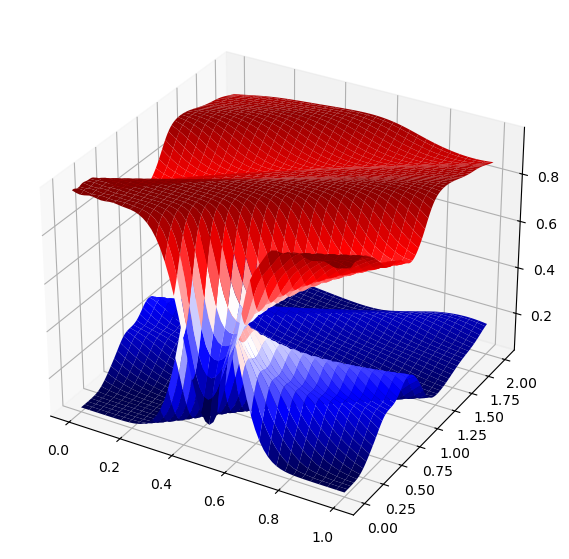

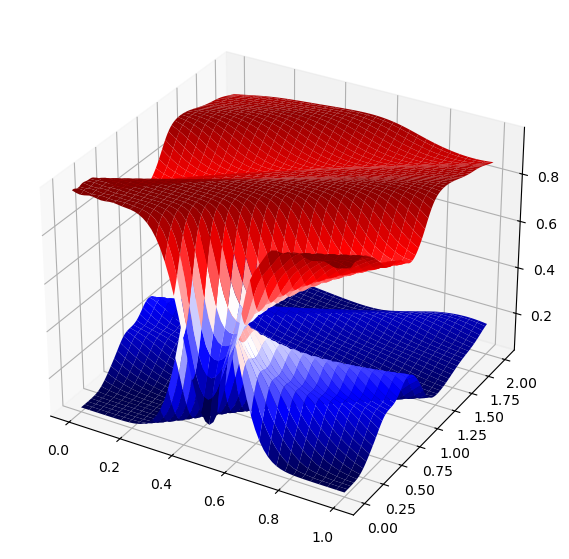

Time elapsed: 9199.66927909851  seconds


In [27]:
u_max = 1.02
rho_max = 1.13
v_max = 0.15
m = 240
n = 40
o = 40
b = 0.3
L = 1
T_max = 2
sigma = 0.001
x = np.linspace(0, L, n)
y = np.linspace(-b, b, o)
t = np.linspace(0, T_max, m)
dt = t[1]-t[0]
dy = y[1]-y[0]
dx = x[1]-x[0]
Y, X = np.meshgrid(y, x)
rhoold = np.zeros((m, n, o))
Cold = 0*np.ones((m, n, o))
np.ones_like(y)
uold = np.zeros_like(Cold)
vold = np.zeros_like(uold)
d1old = np.zeros_like(uold)
d2old = np.zeros_like(uold)
max_iter = 50
start = time.time()
print("Starting the Fixed Point Iteration")
solutions = []
grids = [[o, n, m], [50, 50, 300], [60, 60, 360], [65, 65, 6*65]]#[80, 80, 480]]# [80, 80, 400]]
for j in range(len(grids)):
    error = 2
    o, n, m = grids[j]
    x = np.linspace(0, L, n)
    y = np.linspace(-b, b, o)
    t = np.linspace(0, T_max, m)
    dt = t[1]-t[0]
    dy = y[1]-y[0]
    dx = x[1]-x[0]
    dt = t[1]-t[0]
    dy = y[1]-y[0]
    dx = x[1]-x[0]
    Y, X = np.meshgrid(y, x)
    Z = 0.0565+0.9*np.exp(-1/2*(X-0.5)**2/0.09**2-1/2*Y**2/0.05**2)
    rhoold[0] = Z
    # cost = 0.005*np.ones_like(y)
    # cost[int(o/4):] = 0
    Cold[-1] = -y/10
    print('Current grid size:', m,'x',n,'x',o)
    for iter in range(max_iter):
        rhonew = FPK(m, n, o, dt, dx, dy, rhoold, uold, vold, d1old, d2old, sigma)
        Cnew, unew, vnew, d1new, d2new = HJBI(m, n, o, b, dt, dx, dy, rhoold, uold, vold, d1old, d2old, Cold, sigma)
        Cnew, unew, vnew, d1new, d2new = fictitious_play(iter, Cold, Cnew, uold, unew, vold, vnew, d1old, d1new, d2old, d2new)
        error = np.linalg.norm(rhonew-rhoold)+np.linalg.norm(unew-uold)+np.linalg.norm(vnew-vold)+np.linalg.norm(d1new-d1old)+np.linalg.norm(d2new-d2old)
        clear_output(wait=True)
        print('Current grid size:', m,'x',n,'x',o)
        print('Iteration:', iter+1, 'Total Error:', error)
        print(r'Error $\rho$:', np.linalg.norm(rhonew-rhoold))
        print(r'Error $u$:', np.linalg.norm(unew-uold))
        print(r'Error $v$:', np.linalg.norm(vnew-vold))
        print(r'Error $C$:', np.linalg.norm(Cnew-Cold))
        print(r'Error $d_1$:', np.linalg.norm(d1new-d1old))
        print(r'Error $d_2$:', np.linalg.norm(d2new-d2old))
        print(np.max(vold))
        print(np.min(vold))
        print(np.max(uold))
        print(np.min(uold))
        if iter%3 == 0:
            print('Processing ', np.round((iter+1)/max_iter*100, 2),'\b% complete(/)')
        if iter%3 == 1:
            print('Processing ', np.round((iter+1)/max_iter*100, 2),'\b% complete(–)')
        if iter%3 == 2:
            print('Processing ', np.round((iter+1)/max_iter*100, 2),'\b% complete(\\)')
        rhoold = rhonew
        uold = unew
        vold = vnew
        Cold = Cnew
        d1old = d1new
        d2old = d2new
        X, T = np.meshgrid(x, t)
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, T, uold[:, :, int(o/2)], cmap='seismic')
        ax.plot_surface(X, T, rhoold[:, :, int(o/2)], cmap='seismic')
        plt.show()
        if error>1:
            break
    solutions.append([rhoold, uold, vold, d1old, d2old, Cold])
    X, T = np.meshgrid(x, t)
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, uold[:, :, int(o/2)], cmap='seismic')
    ax.plot_surface(X, T, rhoold[:, :, int(o/2)], cmap='seismic')
    plt.show()
    print('Time elapsed:', time.time()-start, ' seconds')
    
    if j<len(grids)-1:
        o1, n1, m1 = grids[j+1]
        x1 = np.linspace(0, L, n1)
        y1 = np.linspace(-b, b, o1)
        t1 = np.linspace(0, T_max, m1)
        interp_rho = RegularGridInterpolator((t, x, y), rhoold, method='cubic')
        interp_u = RegularGridInterpolator((t, x, y), uold, method='cubic')
        interp_v = RegularGridInterpolator((t, x, y), vold, method='cubic')
        interp_d1 = RegularGridInterpolator((t, x, y), d1old, method='cubic')
        interp_d2 = RegularGridInterpolator((t, x, y), d2old, method='cubic')
        interp_C = RegularGridInterpolator((t, x, y), Cold, method='cubic')
        T1, X1, Y1 = np.meshgrid(t1, x1, y1, indexing='ij')
        points_new = np.stack([T1.ravel(), X1.ravel(), Y1.ravel()], axis=-1)
        rhoold = interp_rho(points_new).reshape(m1, n1, o1)
        uold = interp_u(points_new).reshape(m1, n1, o1)
        vold = interp_v(points_new).reshape(m1, n1, o1)
        d1old = interp_d1(points_new).reshape(m1, n1, o1)
        d2old = interp_d2(points_new).reshape(m1, n1, o1)
        Cold = interp_C(points_new).reshape(m1, n1, o1)
        if error > 1:
            break
solutions.append([rhoold, uold, vold, d1old, d2old, Cold])

In [53]:
65*6

390

In [52]:
import pandas as pd
pd.DataFrame(rhoold.reshape(m, n*o)).to_csv('LWRMFG2_density.csv')
pd.DataFrame(uold.reshape(m, n*o)).to_csv('LWRMFG2_velocitu.csv')
pd.DataFrame(vold.reshape(m, n*o)).to_csv('LWRMFG2_velocitv.csv')
pd.DataFrame(d1old.reshape(m, n*o)).to_csv('LWRMFG2_dist1.csv')
pd.DataFrame(d2old.reshape(m, n*o)).to_csv('LWRMFG2_dist2.csv')
pd.DataFrame(Cold.reshape(m, n*o)).to_csv('LWRMFG2_cost.csv')

In [258]:
rhoold = solutions[-1][0]
uold = solutions[-1][1]
vold = solutions[-1][2]
d1old = solutions[-1][3]
d2old = solutions[-1][4]
Cold = solutions[-1][5]

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (390, 65) and arg 2 with shape (360, 60).

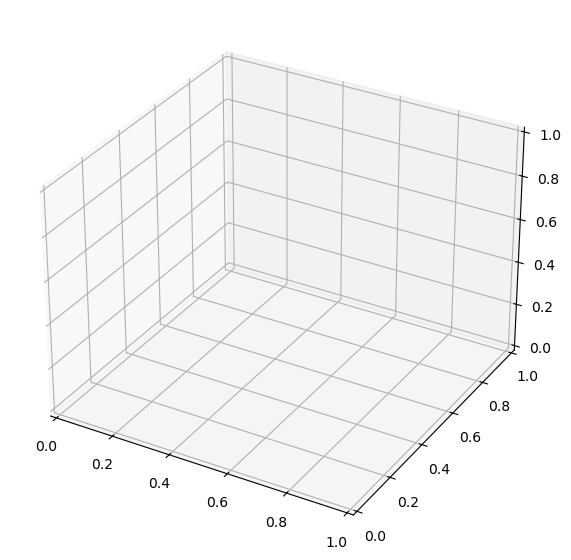

In [259]:
u1 = np.maximum(np.minimum(rhoold, u_max), 0)
X, T = np.meshgrid(x, t)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, rhoold[:, :, -1], cmap='seismic')

In [ ]:
Cold[-1]

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (420, 70) and arg 2 with shape (360, 60).

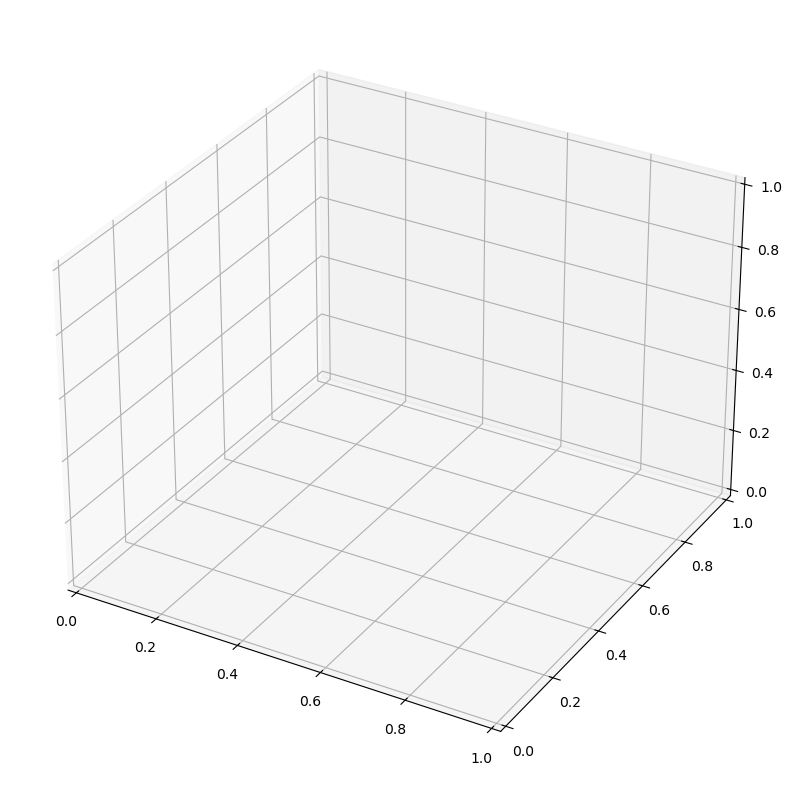

In [39]:
x = np.linspace(0, 1, n)
t = np.linspace(0, 2, m)
X, T = np.meshgrid(x, t)
# X, Y = np.meshgrid(x, y)
# Define the function
# U = rho[:, :, 50]
Z = rhoold[:, :, 30]
# Create the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, Z, cmap='seismic')
# plt.savefig('initial_profile.png', format = 'png', dpi = 600)
# Labels
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel(r'$\rho(x, t)$')
ax.set_title(r'Surface plot of $\rho(t, x)$')
# ax.view_init(elev = 25, azim= 200)

In [59]:
np.max(rhoold[0])

0.8663300602994988

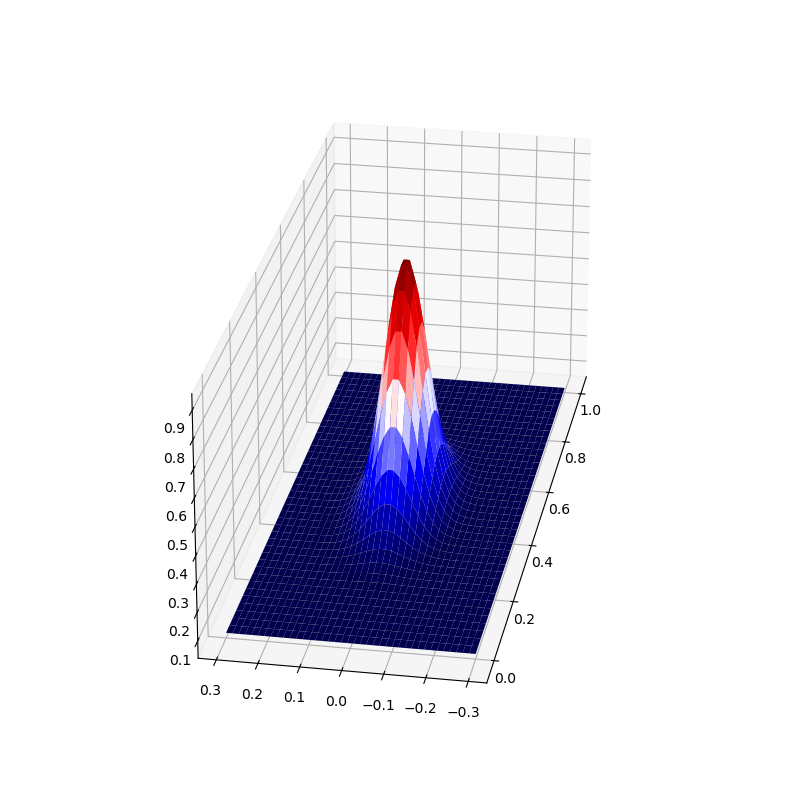

In [24]:
x = np.linspace(0, 1, 40)
t = np.linspace(0, 2, 240)
Y, X = np.meshgrid(y, x)
# X, Y = np.meshgrid(x, y)
# Define the function
# U = rho[:, :, 50]
Z = rhoold[0]
# Create the plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, rhoold[0], cmap='seismic')
ax.set_box_aspect([5, 2, 2]) 
# plt.savefig('initial_profile.png', format = 'png', dpi = 600)
# Labels
# ax.set_xlabel('x')
# ax.set_ylabel('t')
# ax.set_zlabel('u(x, t)')
# ax.set_title('Surface plot of u(x, t) = sin(πx) * exp(-t)')
ax.view_init(elev = 25, azim = 190)

In [108]:
np.linspace(0, 0.015, o)[::-1]

array([0.015     , 0.01478261, 0.01456522, 0.01434783, 0.01413043,
       0.01391304, 0.01369565, 0.01347826, 0.01326087, 0.01304348,
       0.01282609, 0.0126087 , 0.0123913 , 0.01217391, 0.01195652,
       0.01173913, 0.01152174, 0.01130435, 0.01108696, 0.01086957,
       0.01065217, 0.01043478, 0.01021739, 0.01      , 0.00978261,
       0.00956522, 0.00934783, 0.00913043, 0.00891304, 0.00869565,
       0.00847826, 0.00826087, 0.00804348, 0.00782609, 0.0076087 ,
       0.0073913 , 0.00717391, 0.00695652, 0.00673913, 0.00652174,
       0.00630435, 0.00608696, 0.00586957, 0.00565217, 0.00543478,
       0.00521739, 0.005     , 0.00478261, 0.00456522, 0.00434783,
       0.00413043, 0.00391304, 0.00369565, 0.00347826, 0.00326087,
       0.00304348, 0.00282609, 0.0026087 , 0.0023913 , 0.00217391,
       0.00195652, 0.00173913, 0.00152174, 0.00130435, 0.00108696,
       0.00086957, 0.00065217, 0.00043478, 0.00021739, 0.        ])

In [36]:
rhoold = solutions[-1][0]
rhoold.shape
m, n, o = rhoold.shape

In [38]:
Cold.shape

(390, 65, 65)

In [39]:
m

390

In [41]:
rho1 = np.zeros((m+30, n, o))
C1 = np.zeros((m+30, n, o))
rho1[:m] = rhoold
rho1[m:] = rhoold[-1]
C1 = np.zeros((m+30, n, o))
C1[30:] = Cold
C1[:30] = Cold[0]

In [48]:
m, n, o = rhoold.shape
b = 0.3
m1 = m+30
# rho1 = np.zeros((m1, n, o))
# rho1[:m] = rhohat1
# rho1[m:] = rhohat1[-1]
C1 = np.zeros((m+30, n, o))
C1[30:] = Cold
C1[:30] = Cold[0]
x = np.linspace(0, 1, n)
y = np.linspace(-b, b, o)
t = np.linspace(0, 2, m)
dt = t[1]-t[0]
Y, X = np.meshgrid(y, x)
Z = C1[0]
surf = [ax.plot_surface(Y, X, Z, cmap='seismic')]
# Set limits
ax.set_zlim(np.min(C1)-0.01, np.max(C1)+0.01)

# Update function
def update(frame):
    ax.clear()
    Z = C1[frame]
    ax.plot_surface(X, Y, Z, cmap='seismic')
    ax.set_zlim(np.min(C1)-0.01, np.max(C1)+0.01)
    if frame<m:
        ax.set_title(f"2D MFG-LWR Time $t$={np.round(frame*dt, 2)}")
    else:
        ax.set_title(f"2D MFG-LWR Time $t$={np.round(m*dt, 2)}")
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    ax.set_zlabel(r'$\rho$')
    ax.set_box_aspect([5, 2, 2]) 
    ax.view_init(elev = 25, azim= 190)  
    return []

# Animation
ani = FuncAnimation(fig, update, frames= m1, interval=100)
ani.save("C:\\users\\HPC\\Documents\\Physics Informed GPR\\Animations\\Robust MFG 2 cost Attention.gif", writer="pillow", fps=10)
plt.show()

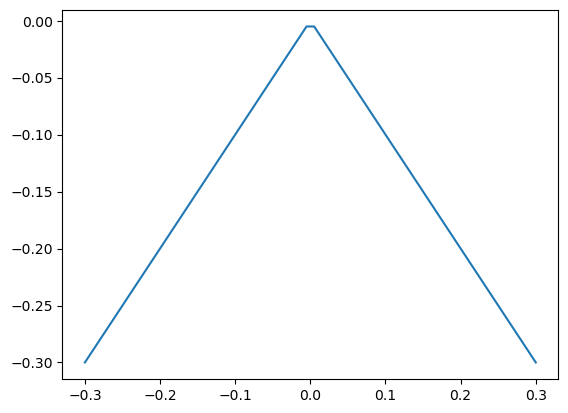

In [210]:
plt.plot(y, -np.abs(y))

In [170]:
rhoold.shape

(360, 60, 60)

In [1]:
320*80*80

2048000